# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

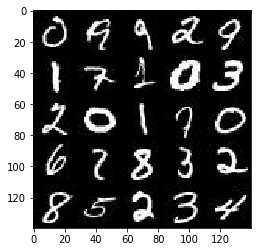

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

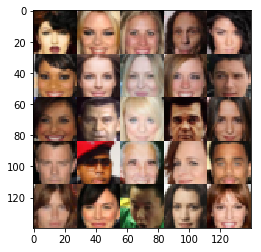

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, shape = (None, image_width, image_height, image_channels), 
                                       name = "input_real")
    z_data = tf.placeholder(tf.float32, shape = (None, z_dim), name = "input_z")
    lr = tf.placeholder(tf.float32, name = "lr")

    return real_input_images, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse = reuse):
        # Build input layer (input_layer 28x28)
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = "same")
        x1 = tf.maximum(alpha * x1, x1)
        #14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides = 2, padding = "same")
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(alpha * x2, x2)
        #7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides = 2, padding = "same")
        x3 = tf.layers.batch_normalization(x3, training = True)
        x3 = tf.maximum(alpha * x3, x3)
        #4x4x256
        
        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)       

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse = not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #2x2x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides = 2, padding = "valid")
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding = "same")
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides = 2, padding = "same")
        #28x28x3
        
        output = tf.tanh(logits)        
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train = True, alpha = alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha = alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True, alpha = alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    
    # Optimize
    d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    deps = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_dep = [dep for dep in deps if dep.name.startswith("generator")]
    with tf.control_dependencies(g_dep):
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    real_input_images, z_data, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(real_input_images, z_data, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_input_images: batch_images, z_data: batch_z, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict= {real_input_images: batch_images, z_data: batch_z, 
                                               lr: learning_rate})
                
                if steps % print_every ==0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_data: batch_z, real_input_images: batch_images})
                    train_loss_g = g_loss.eval({z_data: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:
                    n_images = 32
                    show_generator_output(sess, n_images, z_data, image_channels, data_image_mode)     
               

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.8025... Generator Loss: 0.5718
Epoch 1/2... Discriminator Loss: 2.8780... Generator Loss: 0.2391
Epoch 1/2... Discriminator Loss: 0.6348... Generator Loss: 2.4774
Epoch 1/2... Discriminator Loss: 0.5984... Generator Loss: 1.0800
Epoch 1/2... Discriminator Loss: 0.5456... Generator Loss: 1.6421
Epoch 1/2... Discriminator Loss: 0.1792... Generator Loss: 2.9505
Epoch 1/2... Discriminator Loss: 0.1628... Generator Loss: 8.5623
Epoch 1/2... Discriminator Loss: 3.9704... Generator Loss: 9.1780
Epoch 1/2... Discriminator Loss: 0.0893... Generator Loss: 4.1228
Epoch 1/2... Discriminator Loss: 2.0170... Generator Loss: 5.9904


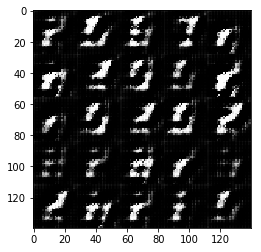

Epoch 1/2... Discriminator Loss: 0.3163... Generator Loss: 2.4928
Epoch 1/2... Discriminator Loss: 0.9521... Generator Loss: 1.8615
Epoch 1/2... Discriminator Loss: 0.3293... Generator Loss: 2.1865
Epoch 1/2... Discriminator Loss: 0.5988... Generator Loss: 1.2136
Epoch 1/2... Discriminator Loss: 0.3935... Generator Loss: 3.0799
Epoch 1/2... Discriminator Loss: 0.4295... Generator Loss: 2.6541
Epoch 1/2... Discriminator Loss: 0.1342... Generator Loss: 3.4358
Epoch 1/2... Discriminator Loss: 0.7788... Generator Loss: 1.1963
Epoch 1/2... Discriminator Loss: 0.3048... Generator Loss: 2.1372
Epoch 1/2... Discriminator Loss: 0.2559... Generator Loss: 2.5318


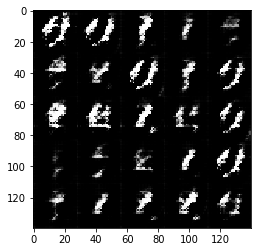

Epoch 1/2... Discriminator Loss: 0.4532... Generator Loss: 2.0345
Epoch 1/2... Discriminator Loss: 0.3823... Generator Loss: 2.1243
Epoch 1/2... Discriminator Loss: 0.6345... Generator Loss: 3.1099
Epoch 1/2... Discriminator Loss: 0.7122... Generator Loss: 0.9706
Epoch 1/2... Discriminator Loss: 0.6263... Generator Loss: 1.6138
Epoch 1/2... Discriminator Loss: 0.3421... Generator Loss: 3.2101
Epoch 1/2... Discriminator Loss: 0.2684... Generator Loss: 2.1217
Epoch 1/2... Discriminator Loss: 0.7872... Generator Loss: 1.1678
Epoch 1/2... Discriminator Loss: 0.5256... Generator Loss: 1.8410
Epoch 1/2... Discriminator Loss: 0.8664... Generator Loss: 0.9791


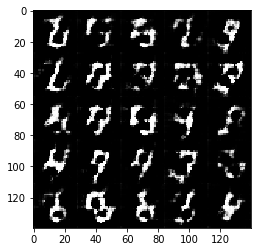

Epoch 1/2... Discriminator Loss: 0.8272... Generator Loss: 1.2066
Epoch 1/2... Discriminator Loss: 1.3375... Generator Loss: 1.8823
Epoch 1/2... Discriminator Loss: 0.5787... Generator Loss: 1.6173
Epoch 1/2... Discriminator Loss: 1.0009... Generator Loss: 0.6402
Epoch 1/2... Discriminator Loss: 1.4572... Generator Loss: 0.7599
Epoch 1/2... Discriminator Loss: 1.9726... Generator Loss: 7.3575
Epoch 1/2... Discriminator Loss: 0.6409... Generator Loss: 1.5174
Epoch 1/2... Discriminator Loss: 0.8960... Generator Loss: 1.7632
Epoch 1/2... Discriminator Loss: 0.6767... Generator Loss: 1.4812
Epoch 1/2... Discriminator Loss: 0.8223... Generator Loss: 1.0567


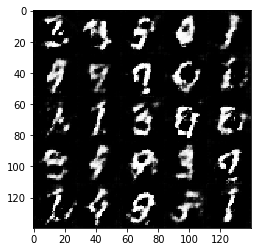

Epoch 1/2... Discriminator Loss: 0.8738... Generator Loss: 1.1052
Epoch 1/2... Discriminator Loss: 0.8296... Generator Loss: 2.3167
Epoch 1/2... Discriminator Loss: 1.3094... Generator Loss: 0.7437
Epoch 1/2... Discriminator Loss: 0.9620... Generator Loss: 0.9888
Epoch 1/2... Discriminator Loss: 0.8889... Generator Loss: 1.6446
Epoch 1/2... Discriminator Loss: 2.1225... Generator Loss: 0.1838
Epoch 1/2... Discriminator Loss: 0.9777... Generator Loss: 2.3021
Epoch 1/2... Discriminator Loss: 0.8346... Generator Loss: 1.6264
Epoch 1/2... Discriminator Loss: 1.0016... Generator Loss: 0.8967
Epoch 1/2... Discriminator Loss: 0.8911... Generator Loss: 0.9142


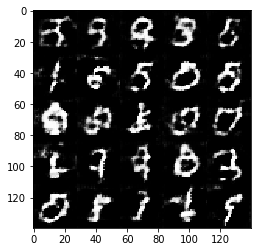

Epoch 1/2... Discriminator Loss: 0.7414... Generator Loss: 1.1725
Epoch 1/2... Discriminator Loss: 0.4759... Generator Loss: 1.9185
Epoch 1/2... Discriminator Loss: 1.3053... Generator Loss: 0.5491
Epoch 1/2... Discriminator Loss: 0.6829... Generator Loss: 2.0458
Epoch 1/2... Discriminator Loss: 1.2415... Generator Loss: 3.0252
Epoch 1/2... Discriminator Loss: 1.9312... Generator Loss: 4.2506
Epoch 1/2... Discriminator Loss: 0.7583... Generator Loss: 1.6981
Epoch 1/2... Discriminator Loss: 0.9001... Generator Loss: 0.8762
Epoch 1/2... Discriminator Loss: 1.5947... Generator Loss: 0.3651
Epoch 1/2... Discriminator Loss: 0.9717... Generator Loss: 1.0694


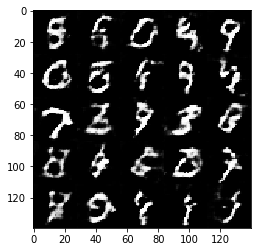

Epoch 1/2... Discriminator Loss: 0.9572... Generator Loss: 1.8577
Epoch 1/2... Discriminator Loss: 0.6847... Generator Loss: 2.0709
Epoch 1/2... Discriminator Loss: 1.2577... Generator Loss: 3.3513
Epoch 1/2... Discriminator Loss: 0.7152... Generator Loss: 1.2760
Epoch 1/2... Discriminator Loss: 0.9849... Generator Loss: 0.8672
Epoch 1/2... Discriminator Loss: 0.7191... Generator Loss: 1.7920
Epoch 1/2... Discriminator Loss: 0.9240... Generator Loss: 2.4030
Epoch 1/2... Discriminator Loss: 0.7989... Generator Loss: 1.2265
Epoch 1/2... Discriminator Loss: 0.9415... Generator Loss: 0.9013
Epoch 1/2... Discriminator Loss: 0.8433... Generator Loss: 1.7330


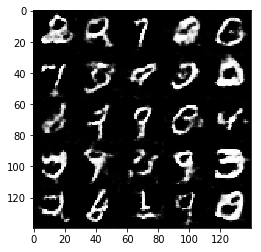

Epoch 1/2... Discriminator Loss: 0.8643... Generator Loss: 0.8310
Epoch 1/2... Discriminator Loss: 1.6316... Generator Loss: 0.3303
Epoch 1/2... Discriminator Loss: 0.9067... Generator Loss: 0.9527
Epoch 1/2... Discriminator Loss: 1.2277... Generator Loss: 0.5599
Epoch 1/2... Discriminator Loss: 1.2432... Generator Loss: 3.2615
Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 0.5022
Epoch 1/2... Discriminator Loss: 0.9266... Generator Loss: 2.2463
Epoch 1/2... Discriminator Loss: 0.7910... Generator Loss: 1.4670
Epoch 1/2... Discriminator Loss: 1.6305... Generator Loss: 0.3455
Epoch 1/2... Discriminator Loss: 1.4265... Generator Loss: 0.5149


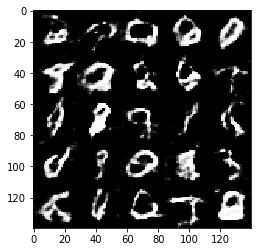

Epoch 1/2... Discriminator Loss: 0.7337... Generator Loss: 1.0673
Epoch 1/2... Discriminator Loss: 0.8711... Generator Loss: 1.2369
Epoch 1/2... Discriminator Loss: 0.9177... Generator Loss: 0.8567
Epoch 1/2... Discriminator Loss: 1.0732... Generator Loss: 1.2083
Epoch 1/2... Discriminator Loss: 1.0181... Generator Loss: 1.1817
Epoch 1/2... Discriminator Loss: 1.0720... Generator Loss: 0.6521
Epoch 1/2... Discriminator Loss: 0.7748... Generator Loss: 1.0661
Epoch 1/2... Discriminator Loss: 1.7241... Generator Loss: 0.4093
Epoch 1/2... Discriminator Loss: 0.9420... Generator Loss: 0.9659
Epoch 1/2... Discriminator Loss: 1.5193... Generator Loss: 2.2191


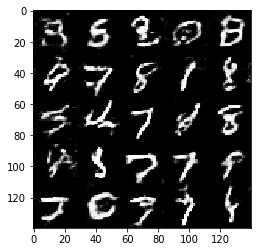

Epoch 1/2... Discriminator Loss: 1.3215... Generator Loss: 0.5022
Epoch 1/2... Discriminator Loss: 1.8974... Generator Loss: 2.9929
Epoch 1/2... Discriminator Loss: 0.9966... Generator Loss: 1.0324
Epoch 2/2... Discriminator Loss: 0.7007... Generator Loss: 1.1994
Epoch 2/2... Discriminator Loss: 1.1206... Generator Loss: 0.6530
Epoch 2/2... Discriminator Loss: 0.8862... Generator Loss: 1.1425
Epoch 2/2... Discriminator Loss: 0.7771... Generator Loss: 1.2504
Epoch 2/2... Discriminator Loss: 1.6893... Generator Loss: 0.3160
Epoch 2/2... Discriminator Loss: 1.2871... Generator Loss: 0.4940
Epoch 2/2... Discriminator Loss: 0.9780... Generator Loss: 0.9838


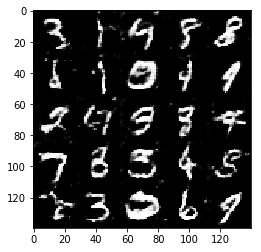

Epoch 2/2... Discriminator Loss: 0.8229... Generator Loss: 0.8299
Epoch 2/2... Discriminator Loss: 0.9469... Generator Loss: 0.8165
Epoch 2/2... Discriminator Loss: 1.1003... Generator Loss: 0.6353
Epoch 2/2... Discriminator Loss: 1.0851... Generator Loss: 1.1897
Epoch 2/2... Discriminator Loss: 1.1750... Generator Loss: 0.5187
Epoch 2/2... Discriminator Loss: 1.2547... Generator Loss: 0.4985
Epoch 2/2... Discriminator Loss: 1.1101... Generator Loss: 2.1899
Epoch 2/2... Discriminator Loss: 1.0987... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 1.0210... Generator Loss: 0.6887
Epoch 2/2... Discriminator Loss: 0.7772... Generator Loss: 2.0777


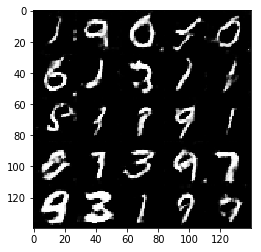

Epoch 2/2... Discriminator Loss: 0.8516... Generator Loss: 1.2155
Epoch 2/2... Discriminator Loss: 0.7971... Generator Loss: 1.4729
Epoch 2/2... Discriminator Loss: 0.9941... Generator Loss: 0.8233
Epoch 2/2... Discriminator Loss: 0.7289... Generator Loss: 1.4801
Epoch 2/2... Discriminator Loss: 0.9608... Generator Loss: 1.0341
Epoch 2/2... Discriminator Loss: 0.9836... Generator Loss: 1.3297
Epoch 2/2... Discriminator Loss: 1.1401... Generator Loss: 1.8623
Epoch 2/2... Discriminator Loss: 1.3528... Generator Loss: 0.4371
Epoch 2/2... Discriminator Loss: 1.4834... Generator Loss: 0.3915
Epoch 2/2... Discriminator Loss: 1.0789... Generator Loss: 0.8882


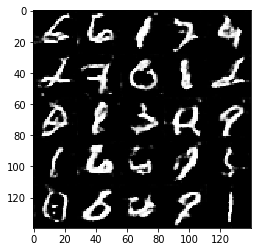

Epoch 2/2... Discriminator Loss: 1.7473... Generator Loss: 0.3031
Epoch 2/2... Discriminator Loss: 0.6500... Generator Loss: 1.4505
Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 0.5466
Epoch 2/2... Discriminator Loss: 1.4050... Generator Loss: 2.6320
Epoch 2/2... Discriminator Loss: 1.3081... Generator Loss: 0.7803
Epoch 2/2... Discriminator Loss: 1.1306... Generator Loss: 1.5622
Epoch 2/2... Discriminator Loss: 1.4624... Generator Loss: 2.8730
Epoch 2/2... Discriminator Loss: 0.9108... Generator Loss: 0.8689
Epoch 2/2... Discriminator Loss: 1.1073... Generator Loss: 0.5682
Epoch 2/2... Discriminator Loss: 1.0772... Generator Loss: 0.6999


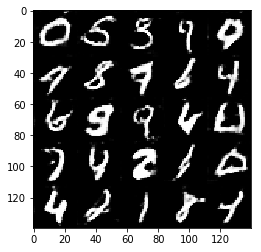

Epoch 2/2... Discriminator Loss: 0.9616... Generator Loss: 1.6161
Epoch 2/2... Discriminator Loss: 0.8064... Generator Loss: 1.2243
Epoch 2/2... Discriminator Loss: 1.0339... Generator Loss: 0.6940
Epoch 2/2... Discriminator Loss: 2.3294... Generator Loss: 0.1649
Epoch 2/2... Discriminator Loss: 1.0045... Generator Loss: 0.9650
Epoch 2/2... Discriminator Loss: 0.9208... Generator Loss: 1.5281
Epoch 2/2... Discriminator Loss: 1.6313... Generator Loss: 3.1766
Epoch 2/2... Discriminator Loss: 0.6189... Generator Loss: 1.8402
Epoch 2/2... Discriminator Loss: 1.1522... Generator Loss: 1.4554
Epoch 2/2... Discriminator Loss: 0.9374... Generator Loss: 1.1518


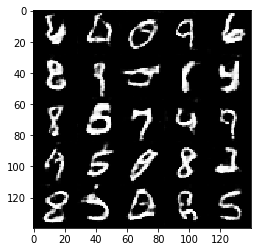

Epoch 2/2... Discriminator Loss: 1.0447... Generator Loss: 0.7443
Epoch 2/2... Discriminator Loss: 0.9356... Generator Loss: 1.0746
Epoch 2/2... Discriminator Loss: 1.5622... Generator Loss: 2.8479
Epoch 2/2... Discriminator Loss: 1.4723... Generator Loss: 0.3883
Epoch 2/2... Discriminator Loss: 1.0433... Generator Loss: 1.5824
Epoch 2/2... Discriminator Loss: 0.6904... Generator Loss: 1.1588
Epoch 2/2... Discriminator Loss: 0.7181... Generator Loss: 0.9979
Epoch 2/2... Discriminator Loss: 1.6344... Generator Loss: 0.4018
Epoch 2/2... Discriminator Loss: 1.2858... Generator Loss: 0.5165
Epoch 2/2... Discriminator Loss: 1.8204... Generator Loss: 3.7273


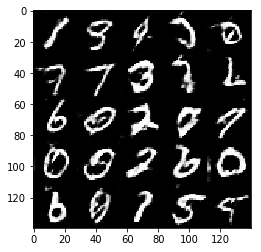

Epoch 2/2... Discriminator Loss: 1.6949... Generator Loss: 0.3156
Epoch 2/2... Discriminator Loss: 1.2315... Generator Loss: 0.7007
Epoch 2/2... Discriminator Loss: 1.6556... Generator Loss: 2.5337
Epoch 2/2... Discriminator Loss: 1.9440... Generator Loss: 3.0422
Epoch 2/2... Discriminator Loss: 0.7817... Generator Loss: 1.0907
Epoch 2/2... Discriminator Loss: 1.1764... Generator Loss: 0.6453
Epoch 2/2... Discriminator Loss: 0.9358... Generator Loss: 1.0130
Epoch 2/2... Discriminator Loss: 1.1877... Generator Loss: 0.6115
Epoch 2/2... Discriminator Loss: 1.7150... Generator Loss: 3.1529
Epoch 2/2... Discriminator Loss: 1.0512... Generator Loss: 1.3664


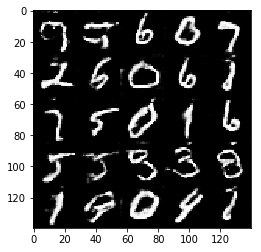

Epoch 2/2... Discriminator Loss: 0.9998... Generator Loss: 0.8623
Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 0.7681
Epoch 2/2... Discriminator Loss: 0.9783... Generator Loss: 0.8858
Epoch 2/2... Discriminator Loss: 0.6909... Generator Loss: 1.0065
Epoch 2/2... Discriminator Loss: 0.9618... Generator Loss: 2.8863
Epoch 2/2... Discriminator Loss: 0.7899... Generator Loss: 1.5539
Epoch 2/2... Discriminator Loss: 0.7634... Generator Loss: 0.9740
Epoch 2/2... Discriminator Loss: 1.4816... Generator Loss: 3.3250
Epoch 2/2... Discriminator Loss: 0.6681... Generator Loss: 1.6111
Epoch 2/2... Discriminator Loss: 0.6955... Generator Loss: 1.5511


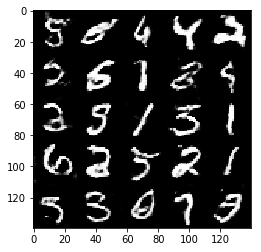

Epoch 2/2... Discriminator Loss: 0.9194... Generator Loss: 0.7493
Epoch 2/2... Discriminator Loss: 1.1236... Generator Loss: 0.6236
Epoch 2/2... Discriminator Loss: 2.5782... Generator Loss: 0.2306
Epoch 2/2... Discriminator Loss: 1.1681... Generator Loss: 1.7713
Epoch 2/2... Discriminator Loss: 0.6165... Generator Loss: 2.4361
Epoch 2/2... Discriminator Loss: 1.0527... Generator Loss: 0.6396
Epoch 2/2... Discriminator Loss: 1.3994... Generator Loss: 2.6178
Epoch 2/2... Discriminator Loss: 0.8906... Generator Loss: 0.9701
Epoch 2/2... Discriminator Loss: 1.4107... Generator Loss: 0.4765
Epoch 2/2... Discriminator Loss: 0.7672... Generator Loss: 1.2083


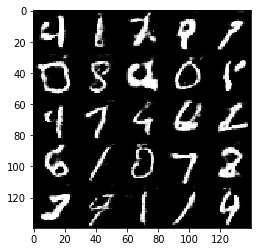

Epoch 2/2... Discriminator Loss: 0.8528... Generator Loss: 0.8624
Epoch 2/2... Discriminator Loss: 0.6189... Generator Loss: 1.1430
Epoch 2/2... Discriminator Loss: 0.8380... Generator Loss: 0.8749
Epoch 2/2... Discriminator Loss: 0.3782... Generator Loss: 1.9550
Epoch 2/2... Discriminator Loss: 0.7791... Generator Loss: 1.0889
Epoch 2/2... Discriminator Loss: 1.7242... Generator Loss: 4.3028
Epoch 2/2... Discriminator Loss: 0.7715... Generator Loss: 1.4508


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7826... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 2.1005... Generator Loss: 1.3521
Epoch 1/1... Discriminator Loss: 0.8030... Generator Loss: 9.2154
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 6.5708
Epoch 1/1... Discriminator Loss: 2.2036... Generator Loss: 6.9319
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 1.3546
Epoch 1/1... Discriminator Loss: 0.4308... Generator Loss: 2.4161
Epoch 1/1... Discriminator Loss: 0.5828... Generator Loss: 4.6427
Epoch 1/1... Discriminator Loss: 0.5730... Generator Loss: 2.1759
Epoch 1/1... Discriminator Loss: 0.3720... Generator Loss: 2.0364


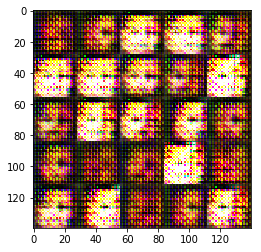

Epoch 1/1... Discriminator Loss: 1.9071... Generator Loss: 6.0451
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 0.3183... Generator Loss: 2.6720
Epoch 1/1... Discriminator Loss: 0.3387... Generator Loss: 1.9260
Epoch 1/1... Discriminator Loss: 0.0476... Generator Loss: 4.8757
Epoch 1/1... Discriminator Loss: 0.1168... Generator Loss: 3.0749
Epoch 1/1... Discriminator Loss: 0.1203... Generator Loss: 2.9423
Epoch 1/1... Discriminator Loss: 1.5994... Generator Loss: 0.3058
Epoch 1/1... Discriminator Loss: 0.4536... Generator Loss: 1.9364
Epoch 1/1... Discriminator Loss: 0.4230... Generator Loss: 2.1119


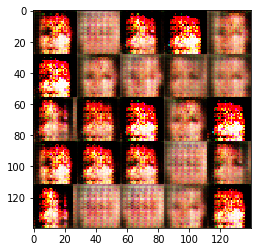

Epoch 1/1... Discriminator Loss: 0.4657... Generator Loss: 1.5345
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.5318
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.4709
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.4068
Epoch 1/1... Discriminator Loss: 4.0898... Generator Loss: 5.9952
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 2.2986
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 1.7283
Epoch 1/1... Discriminator Loss: 0.6913... Generator Loss: 1.0010
Epoch 1/1... Discriminator Loss: 0.8190... Generator Loss: 1.0970


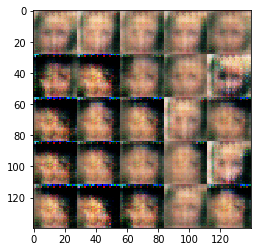

Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 1.9096
Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.6077... Generator Loss: 2.7092
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.5816... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 0.7295... Generator Loss: 1.4622
Epoch 1/1... Discriminator Loss: 1.6540... Generator Loss: 0.4711
Epoch 1/1... Discriminator Loss: 0.3023... Generator Loss: 2.2534
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.8598


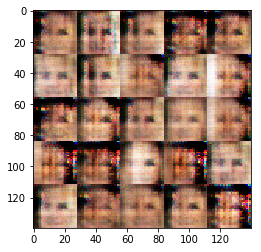

Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.4361
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.0809
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 1.7061
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 0.7672... Generator Loss: 1.1496
Epoch 1/1... Discriminator Loss: 3.0555... Generator Loss: 3.7984
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.9621


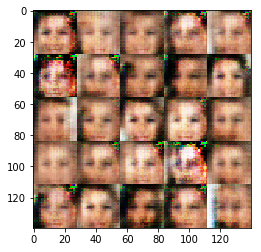

Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 1.7768
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 2.1420
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 2.7690... Generator Loss: 0.1034
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 2.2032... Generator Loss: 0.1634
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 2.2827
Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.5488


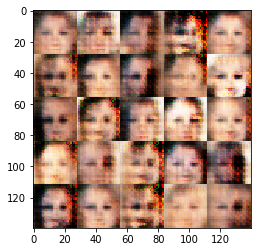

Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 0.3765
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 2.2056
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.4983
Epoch 1/1... Discriminator Loss: 1.6890... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 1.8971
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 1.3460
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.7547


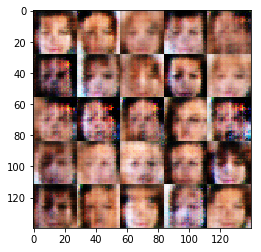

Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 1.2766
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 1.5730
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 2.3021... Generator Loss: 0.1874
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.1116
Epoch 1/1... Discriminator Loss: 2.2143... Generator Loss: 3.4964
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 1.2127
Epoch 1/1... Discriminator Loss: 0.9225... Generator Loss: 1.8055
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 0.9748


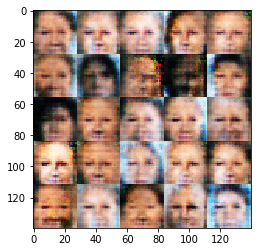

Epoch 1/1... Discriminator Loss: 0.7543... Generator Loss: 1.7767
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 1.4555
Epoch 1/1... Discriminator Loss: 2.3231... Generator Loss: 0.1837
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 1.5979
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 1.5715
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 0.9898... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 2.1865... Generator Loss: 0.1938
Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 0.9763


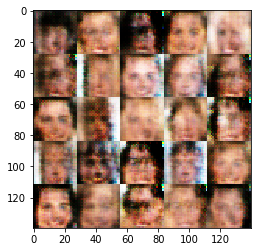

Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 1.5650
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 1.7697
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 0.9942... Generator Loss: 1.2799
Epoch 1/1... Discriminator Loss: 1.5677... Generator Loss: 0.3525
Epoch 1/1... Discriminator Loss: 0.8667... Generator Loss: 0.8822


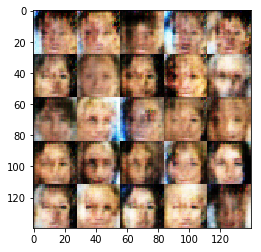

Epoch 1/1... Discriminator Loss: 1.6340... Generator Loss: 2.3175
Epoch 1/1... Discriminator Loss: 0.9069... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 0.7846... Generator Loss: 1.8605
Epoch 1/1... Discriminator Loss: 0.7432... Generator Loss: 1.6380
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 2.1667
Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 1.5304
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 1.4132
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 1.7402
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 0.9011


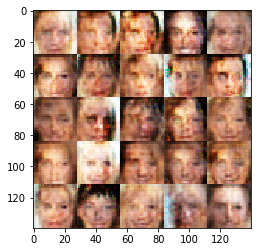

Epoch 1/1... Discriminator Loss: 0.8071... Generator Loss: 1.0888
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.5325
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 1.7113
Epoch 1/1... Discriminator Loss: 0.9472... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 1.0912
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.4411
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 1.8894
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 2.0270
Epoch 1/1... Discriminator Loss: 0.8139... Generator Loss: 1.3597


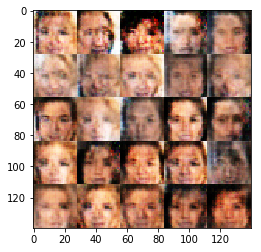

Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.5308
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 0.4050
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.0397
Epoch 1/1... Discriminator Loss: 1.8877... Generator Loss: 0.2462
Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 1.0332


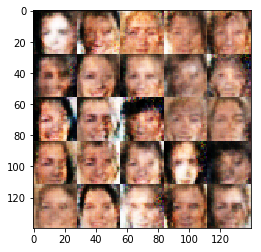

Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 1.7934
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.1615
Epoch 1/1... Discriminator Loss: 0.7642... Generator Loss: 1.1853
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 1.1585
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 1.1774
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 1.1593
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 1.0678
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 1.8988
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.7489


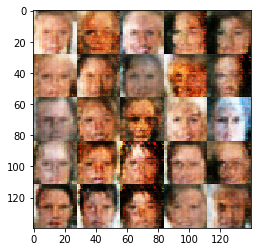

Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.4485
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 1.3714
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.5512
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 2.8182


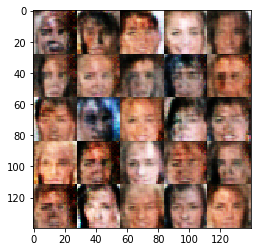

Epoch 1/1... Discriminator Loss: 1.9043... Generator Loss: 0.2532
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 1.8033
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 1.8305
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 1.0048
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.5328


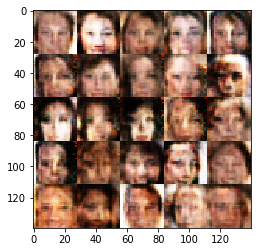

Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 1.2598
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.5146
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 1.1070
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 1.0423
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 1.4520


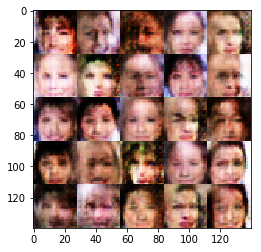

Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 1.3786
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.9580... Generator Loss: 0.2151
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 0.8381... Generator Loss: 1.1000
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.6724


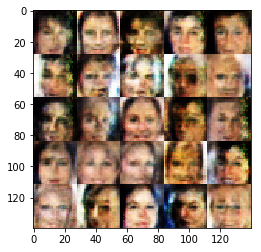

Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.6167... Generator Loss: 0.3643
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 1.0840
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 2.4802
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.4090
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 1.4171


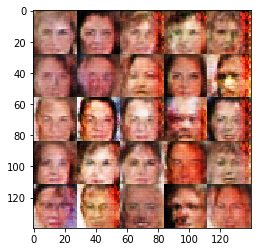

Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.7088
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 1.0983
Epoch 1/1... Discriminator Loss: 1.8401... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.4097
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.5016


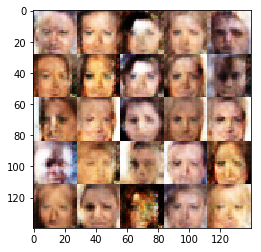

Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 1.4230
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 1.3904
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 1.5034
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.5440
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.4751
Epoch 1/1... Discriminator Loss: 0.9637... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.5106


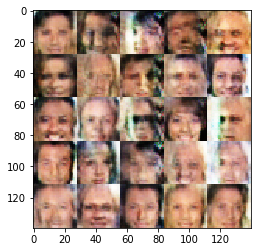

Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.4423
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 1.0788
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 1.0254
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 1.5752
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.4132
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 1.8685


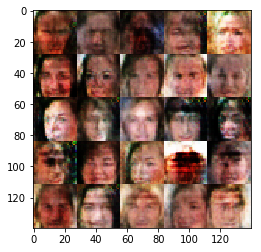

Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.5286... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.5276
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 0.8607... Generator Loss: 1.5557
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 1.3506
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.5002


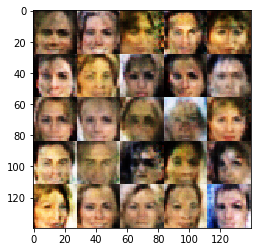

Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 0.8774... Generator Loss: 1.4925
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 0.9977... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 0.9534


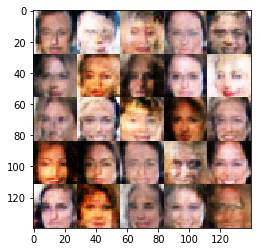

Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 1.1053
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 2.5011
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 1.6688
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.5054
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 0.8624


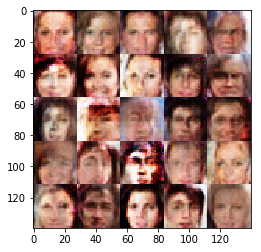

Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 1.2752
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 1.4233
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 1.7604
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.7223... Generator Loss: 0.2913
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 1.4182
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 0.8585


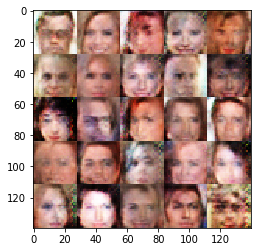

Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.4828
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 0.9753
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.5398
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.4055
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 1.3675
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.3829


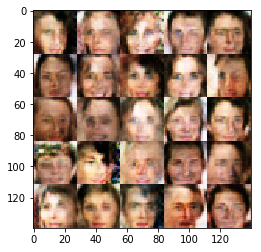

Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 1.3753
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 1.3336
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 1.2319
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.6489


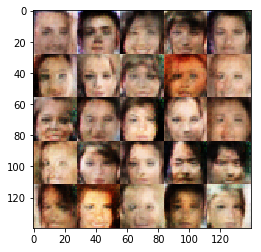

Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 1.2031
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 1.6911
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.3960
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 1.2921
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.3680


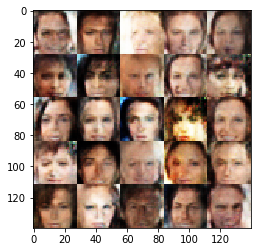

Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 0.8570... Generator Loss: 1.4088
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.5012
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 1.4645
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.3679
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 0.8129... Generator Loss: 1.2727


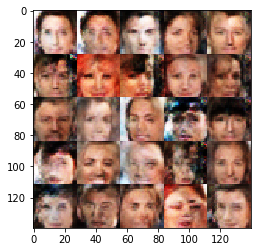

Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.5167
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 1.6360
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.3880
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.6573... Generator Loss: 0.3094
Epoch 1/1... Discriminator Loss: 1.8978... Generator Loss: 2.2063


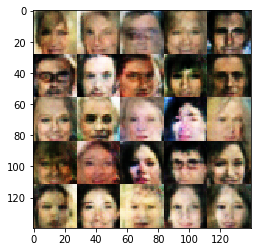

Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 0.7844... Generator Loss: 1.3262
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 1.0347
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.2056
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 0.7786


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.